# 1 and 2: Preparation and Data Set

In [172]:
import numpy as np 

#Possible combinations of inputs
inputs = np.array([[0,0],[0,1],[1,0],[1,1]])

#Target results for each logical gate. The array index matches the index of the corresponding input in the "inputs" array.
target_and = np.array([0,0,0,1])
target_or = np.array([0,1,1,1])
target_nand = np.array([1,1,1,0])
target_nor = np.array([1,0,0,0])
target_xor = np.array([0,1,1,0])

#Sigmoid function
def sigmoid(x): 
    return (1 / (1 + np.exp(-x)))

#Derivative of Sigmoid
def sigmoidprime(x):
    return (sigmoid(x) * (1 - sigmoid(x)))

# 3: Perceptron class

In [177]:
class Perceptron:
    
    def __init__(self, input_units):
        #Amount of input units
        self.input_units = input_units
        #Initializes the incoming weights and the bias randomly.
        self.weights = np.random.randn(input_units)
        self.bias = np.random.randn()
        #Learning rate alpha
        self.alpha = 1
        #Current drive/input of activation (needs to be stored for the "update" function). Will be overwritten after every "forward_step".
        self.current_drive_of_activation = 0
        
    def forward_step(self, inputs):
        #Conducts a forward step.
        #Calculates the drive/the input of the activation function and stores it, because it is needed to calculate the error term during the backpropagation (function "update").
        self.current_drive_of_activation = np.dot(inputs, self.weights) + self.bias 
        
        #Applies the activation function sigmoid.
        activation = sigmoid(self.current_drive_of_activation)
        return activation             
    
    def update(self, delta, inputs):
        #Calculates the error term.
        error_term = delta * sigmoidprime(self.current_drive_of_activation)
        
        #Updates each weight.
        for i in range(len(self.weights)):
            #Calculation dependend on the corresponding input of each weight.
            delta_of_current_weight = error_term * inputs[i]
            #Updates the corresponding weight.
            self.weights[i] -= self.alpha * delta_of_current_weight 
        
        #Updates the bias.
        delta_bias = error_term * 1
        self.bias -= self.alpha * delta_bias
        
        #Calculates the weighted deltas for the neurons in the preceding layer. This is necessary to continue the backpropagation
        #troughout the entire ANN.
        weighted_deltas = np.empty(self.input_units)   #As many weighted deltas as weights ("input_units")
        #Seperate Calculation for each preceding neuron
        for i in range(len(weighted_deltas)):
            weighted_deltas[i] = error_term * self.weights[i]
        return weighted_deltas 

# 4: Multi-Layer Perceptron class

In [178]:
class MLP:
    
    def __init__(self, size_hidden_layer):
        #Size of hidden layer
        self.size_hidden_layer = size_hidden_layer
        
        #Initializes the hidden layer (A list filled with the neurons/perceptrons of the hidden layer).
        self.hidden_layer = [None for i in range(size_hidden_layer)]
        amount_of_inputs = 2                                     #Two binary inputs of the logical gate
        for i in range(len(self.hidden_layer)):
            self.hidden_layer[i] = Perceptron(amount_of_inputs)  #The instances of the Perceptron class are stored in the list.
        
        #Array to store the returned activations of the Perceptrons in the hidden layer. Thus it has the same shape like the hidden layer.
        self.activations_of_hidden_layer = np.empty(size_hidden_layer)
        
        #Initializes the output layer. In this case just one neuron.
        self.output_layer = Perceptron(size_hidden_layer)
        
    def forward_step(self, inputs):
        #Firstly, the activations of the hidden layer are computed by iterating over the Perceptrons in the array "hidden_layer" and calling the "forward_step" function of the class Perceptron.
        for i in range(len(self.activations_of_hidden_layer)):
            self.activations_of_hidden_layer[i] = self.hidden_layer[i].forward_step(inputs)
            
        #Secondly, the activation of the output layer is computed.
        output = self.output_layer.forward_step(self.activations_of_hidden_layer)
        
        #Returns the output, which is the prediction value of the ANN.
        return output
        
    def backprop_step(self, delta, inputs):
        #Firstly, the output layer is updated and the returned weighted deltas for the preceding hidden layer are stored.
        weighted_deltas_for_hidden_layer = self.output_layer.update(delta, self.activations_of_hidden_layer)
            
        #Secondly, the hidden layer is updated. In this case the returned weighted deltas for the preceding hidden layer are irrelevant, because the preceding layer is the input layer.
        for i in range(len(self.hidden_layer)):
            self.hidden_layer[i].update(weighted_deltas_for_hidden_layer[i], inputs)
        

# 5: Training

In [187]:
#Defines the size of the hidden layer.
size_hidden_layer = 4
#Defines the logical gate which should be learned. This is done by choosing the corresponding target result array.
target = target_xor    #target_and, target_or, target_nand, target_nor, target_xor

#Initializes the corresponding Multi-Layer Perceptron.
logical_gate = MLP(size_hidden_layer)

#Defines the amount of training epochs.
amount_of_training_epochs = 1000
#Initializes the arrays to store the steps and the average loss and accurcy of each epoch.
steps = np.empty(amount_of_training_epochs)
average_loss_each_epoch = np.empty(amount_of_training_epochs)
average_accuracy_each_epoch = np.empty(amount_of_training_epochs)

#Conducts the training epochs.
for epoch in range(amount_of_training_epochs):
    #Stores the current epoch step.
    steps[epoch] = epoch
    #Defines the counting variables which are necessary to compute the average loss and accuray. 
    loss_each_epoch = 0
    correct_predictions_each_epoch = 0
    
    #Loops over each point in the input-dataset once.
    for i in range(len(inputs)):
        #Performs a forward step which returns the prediction.
        prediction = logical_gate.forward_step(inputs[i])
    
        #Calculates the loss of the current forward step. 
        loss_each_epoch += np.square(target[i] - prediction)
    
        #Increments the "correct_predictions_each_epoch" count if the current predictions is correct.
        if (prediction <= 0.5 and target[i] == 0) or (prediction > 0.5 and target[i] == 1):
            correct_predictions_each_epoch += 1
    
        #Calculates the delta between target and prediction which is given to the "backprop_step" function afterwards.
        delta = -(target[i] - prediction)
        #Performs the corresponding backpropagation step.
        logical_gate.backprop_step(delta, inputs[i])
    
    #Updates the average loss and accurcy arrays. "len(inputs)" returns the amount of training examples
    average_loss_each_epoch[epoch] = loss_each_epoch / len(inputs) 
    average_accuracy_each_epoch[epoch] = correct_predictions_each_epoch / len(inputs)

# 6: Visualization

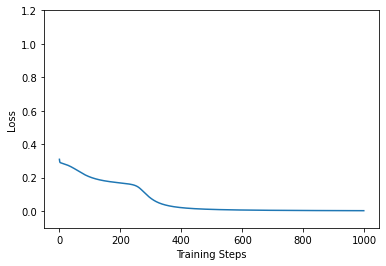

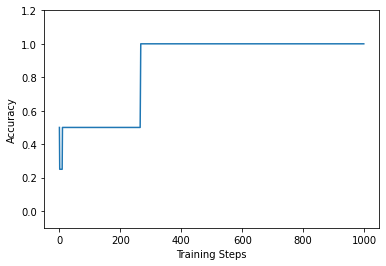

In [188]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(steps, average_loss_each_epoch)
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.ylim([-0.1, 1.2])
plt.show()

plt.figure()
plt.plot(steps, average_accuracy_each_epoch)
plt.xlabel("Training Steps")
plt.ylabel("Accuracy")
plt.ylim([-0.1, 1.2])
plt.show()